![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a **MSE of 3 or less on a test set**. The model you make will help the company become more efficient with their inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read in the csv file
df_raw = pd.read_csv('./data/rental_info.csv',
                     parse_dates = ['rental_date', 'return_date'])
print(df_raw.shape)
print(df_raw.columns)
print(df_raw.info())
df_raw.head()  # no missing values (15861 Non-Null Count all columns)

(15861, 15)
Index(['rental_date', 'return_date', 'amount', 'release_year', 'rental_rate',
       'length', 'replacement_cost', 'special_features', 'NC-17', 'PG',
       'PG-13', 'R', 'amount_2', 'length_2', 'rental_rate_2'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   rental_date       15861 non-null  datetime64[ns, UTC]
 1   return_date       15861 non-null  datetime64[ns, UTC]
 2   amount            15861 non-null  float64            
 3   release_year      15861 non-null  float64            
 4   rental_rate       15861 non-null  float64            
 5   length            15861 non-null  float64            
 6   replacement_cost  15861 non-null  float64            
 7   special_features  15861 non-null  object             
 8   NC-17             15861 non-null  int64          

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [3]:
df_raw['release_year'] = df_raw['release_year'].astype('int')

In [4]:
# Create "rental_length_days" col using the "return_date" and "rental_date" cols
df_raw["rental_length_days"] = df_raw["return_date"] - df_raw["rental_date"]
print(f"rental_length_days datatype: {df_raw['rental_length_days'].dtype}")
df_raw["rental_length_days_int"] = df_raw["rental_length_days"].dt.days
df_raw["rental_length_days"] = df_raw["rental_length_days"].dt.total_seconds() / (60 * 60 * 24)
df_raw.head()

rental_length_days datatype: timedelta64[ns]


,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,rental_length_days_int
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3.865278,3
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2.836806,2
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7.238889,7
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2.100000,2
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4.045139,4


In [5]:
# create deleted_scenes and behind_the_scenes cols
df_raw["deleted_scenes"] = df_raw["special_features"].apply(lambda x: 1 if "Deleted Scenes" in x else 0)
df_raw["behind_the_scenes"] = df_raw["special_features"].apply(lambda x: 1 if "Behind the Scenes" in x else 0)
df_raw.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,rental_length_days_int,deleted_scenes,behind_the_scenes
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3.865278,3,0,1
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2.836806,2,0,1
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7.238889,7,0,1
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2.100000,2,0,1
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4.045139,4,0,1


## Data leakage

+ The `amount` is determined ***after*** the DVD has been returned. In other word, `amount` is determined by the target `rental_length_days` and not the other way around therefore the `amount` feature *leaks* information about the target (`rental_length_days`), so it should **NOT** be used as a predictor.
+ For the same reason that `amount` should not be used, `amount_2` (the square of `amount`) should not be used either.
+ Notice the correlation between `amount` and `rental_length_days` and the corresponding scatter plot below.

Correlation between rental length and amount: 0.5573509800734


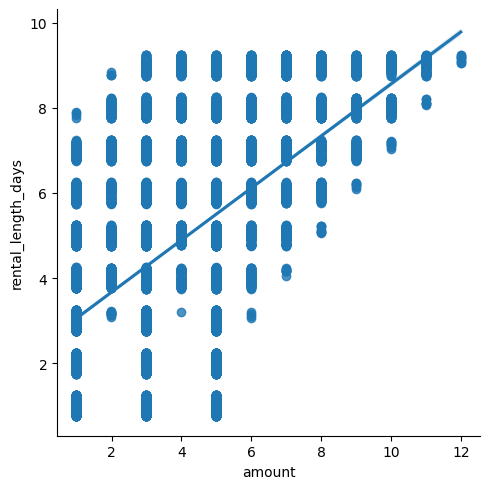

In [6]:
length_amount_corr =df_raw['amount'].corr(df_raw['rental_length_days'])
print(f"Correlation between rental length and amount: {length_amount_corr}")

sns.lmplot(data=df_raw, x='amount', y='rental_length_days')
plt.show()

## Baseline model: target mean

The simplest model we could use to predict rental length is simply the mean of the training data. This will serve as our baseline.

In [7]:
# create initial feature matrix
init_feature_cols = ['rental_rate', 'rental_rate_2', 'release_year', 'length', 'length_2',
                    'replacement_cost', 'NC-17', 'PG', 'PG-13', 'R', 'deleted_scenes', 'behind_the_scenes']
X_01 = df_raw[init_feature_cols]
# specify the target
y = df_raw['rental_length_days']

In [8]:
# split into train and test sets
SEED = 9
X_train, X_test, y_train, y_test = train_test_split(X_01, y,
                                                    test_size=0.2,
                                                    random_state=SEED)
print(f"Training feature matrix shape: {X_train.shape}, Testing feature matrix shape: {X_test.shape}")
print(f"Training target vector shape: {y_train.shape}, Testing target vector shape: {y_test.shape}")

Training feature matrix shape: (12688, 12), Testing feature matrix shape: (3173, 12)
Training target vector shape: (12688,), Testing target vector shape: (3173,)


In [9]:
mean_target_train = y_train.mean()
square_errors = (y_test - mean_target_train) ** 2
mse_mean_target_model = square_errors.mean()
print(f"MSE target mean model = {mse_mean_target_model:.2f}")

MSE target mean model = 6.82


## Exploratory Data Analysis (EDA)

Takin a look at how each of the features are related to the target, we see that:

1. Moving rating ('NC-17', 'PG', 'PG-13', 'R' or NOT RATED) by itself shows no perceptible impact on rental length
2. Whether special content is either included or not, by itself shows no perceptible impact on rental length
3. tbd

In [10]:
binary_feats = ['NC-17', 'PG', 'PG-13', 'R', 'deleted_scenes', 'behind_the_scenes']
df_rated = df_raw.loc[:, ['NC-17', 'PG', 'PG-13', 'R', 'rental_length_days']]
df_rated.loc[:, 'R'] = df_rated['R'] * 4
df_rated.loc[:, 'PG-13'] = df_rated['PG-13'] * 3
df_rated.loc[:, 'PG'] = df_rated['PG'] * 2
# leave NC-17 as 0 or 1
df_rated['rated_index'] = df_rated['NC-17'] + df_rated['PG'] + df_rated['PG-13'] + df_rated['R']

def convert_rated(rate_index):
    if rate_index == 4:
        return 'R'
    elif rate_index == 3:
        return 'PG-13'
    elif rate_index == 2:
        return 'PG'
    elif rate_index == 1:
        return 'NC-17'
    else:
        return 'NOT RATED'

df_rated['rated'] = df_rated['rated_index'].apply(lambda x: convert_rated(x))
# df_rated.iloc[50:100]

In [11]:
df_rated['rated'].value_counts()

rated
PG-13        3543
NC-17        3249
PG           3177
R            3152
NOT RATED    2740
Name: count, dtype: int64

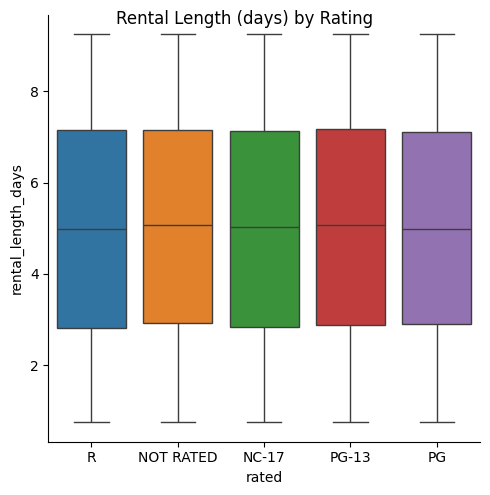

In [12]:
g1 = sns.catplot(x='rated',
                y='rental_length_days',
                data=df_rated,
                kind='box',
                hue='rated')
g1.fig.suptitle("Rental Length (days) by Rating")
plt.show()

In [17]:
df_specials = df_raw.loc[:, ['deleted_scenes', 'behind_the_scenes', 'rental_length_days']]
df_specials['special_index'] = df_specials['deleted_scenes'] + (2 * df_specials['behind_the_scenes'])

def convert_specials(s):
    if s == 3:
        return 'both_deleted_and_behind_scenes'
    elif s == 2:
        return 'behind_scenes_only'
    elif s == 1:
        return 'deleted_scenes_only'
    else:
        return 'neither_deleted_or_behind_scenes'

df_specials['specials'] = df_specials['special_index'].apply(lambda x: convert_specials(x))

df_specials['specials'].value_counts()

specials
behind_scenes_only                  4616
deleted_scenes_only                 3997
both_deleted_and_behind_scenes      3891
neither_deleted_or_behind_scenes    3357
Name: count, dtype: int64

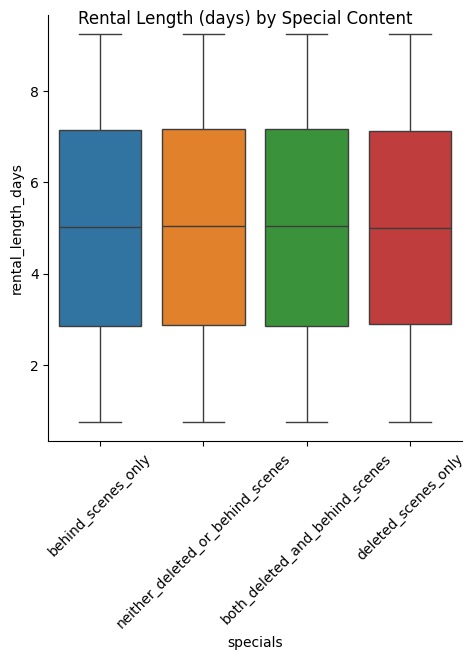

In [21]:
g2 = sns.catplot(x='specials',
                y='rental_length_days',
                data=df_specials,
                kind='box',
                hue='specials')
g2.fig.suptitle("Rental Length (days) by Special Content")
plt.xticks(rotation=45)
plt.show()